In [16]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
import random 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}

In [10]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)   
    Y = torch.tensor(Y)   
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train= build_dataset(words[:n1])
X_dev, Y_dev= build_dataset(words[n1:n2])
X_test, Y_test= build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [31]:
vocab_size = 27
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483657)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,  generator=g) * (5/3) /((n_embd * block_size))**0.5 # kaiming (he) init with tanh gain (5/3) https://pytorch.org/docs/stable/nn.init.html
b1 = torch.randn(n_hidden, generator=g)*0.01
W2 = torch.randn(n_hidden, vocab_size,  generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

parameters = [C, W1, W2, b2]
print(f"{sum(p.nelement() for p in parameters)} total weights")
for p in parameters: 
    p.requires_grad = True

11697 total weights


In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X,Y

    #forward pass
    emb=C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: # print every once in a white
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3030
  10000/ 200000: 2.6269
  20000/ 200000: 2.4533
  30000/ 200000: 2.4104
  40000/ 200000: 2.4353
  50000/ 200000: 2.2953
  60000/ 200000: 2.0096
  70000/ 200000: 2.1973
  80000/ 200000: 2.4549
  90000/ 200000: 2.0121
 100000/ 200000: 1.8472
 110000/ 200000: 2.1114
 120000/ 200000: 2.0856
 130000/ 200000: 1.8660
 140000/ 200000: 2.1530
 150000/ 200000: 1.9591
 160000/ 200000: 2.1892
 170000/ 200000: 1.9762
 180000/ 200000: 1.8566
 190000/ 200000: 2.4721


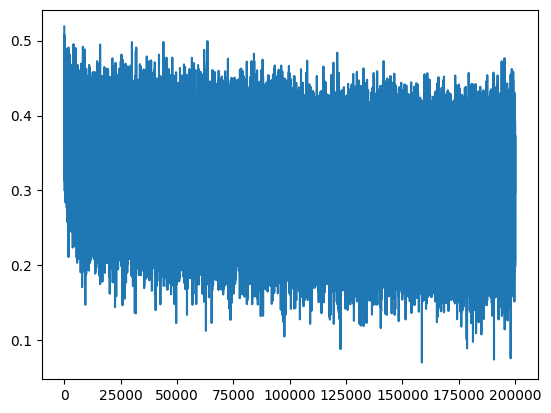

In [28]:
# so after weight initialization we don't get a hockey stick appearance of the loss anymore and instead get some of the hard gains of decreasing the loss!
plt.plot(lossi)

(array([1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 1.000e+01,
        1.300e+01, 2.000e+01, 3.300e+01, 2.800e+01, 5.400e+01, 7.700e+01,
        6.800e+01, 8.200e+01, 1.040e+02, 1.210e+02, 1.210e+02, 1.560e+02,
        2.070e+02, 2.770e+02, 4.410e+02, 2.249e+03, 7.050e+02, 3.420e+02,
        2.400e+02, 1.840e+02, 1.730e+02, 1.300e+02, 1.130e+02, 1.220e+02,
        8.000e+01, 5.700e+01, 4.600e+01, 3.700e+01, 3.400e+01, 2.200e+01,
        1.000e+01, 1.000e+01, 7.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-9.80804062, -9.35826929, -8.90849796, -8.45872663, -8.00895531,
        -7.55918398, -7.10941265, -6.65964132, -6.20987   , -5.76009867,
        -5.31032734, -4.86055601, -4.41078468, -3.96101336, -3.51124203,
        -3.0614707 , -2.61169937, -2.16192804, -1.71215672, -1.26238539,
        -0.81261406, -0.36284273,  0.0869286 ,  0.53669992,  0.98647125,
         1.

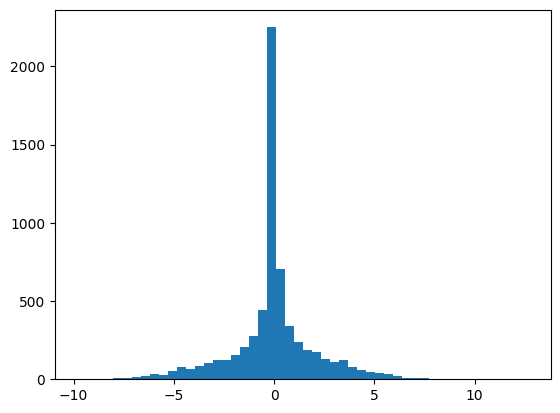

In [29]:
# preactivation values, extreme values will always cause saturated neuron for tanh
plt.hist(hpreact.view(-1).tolist(), 50)

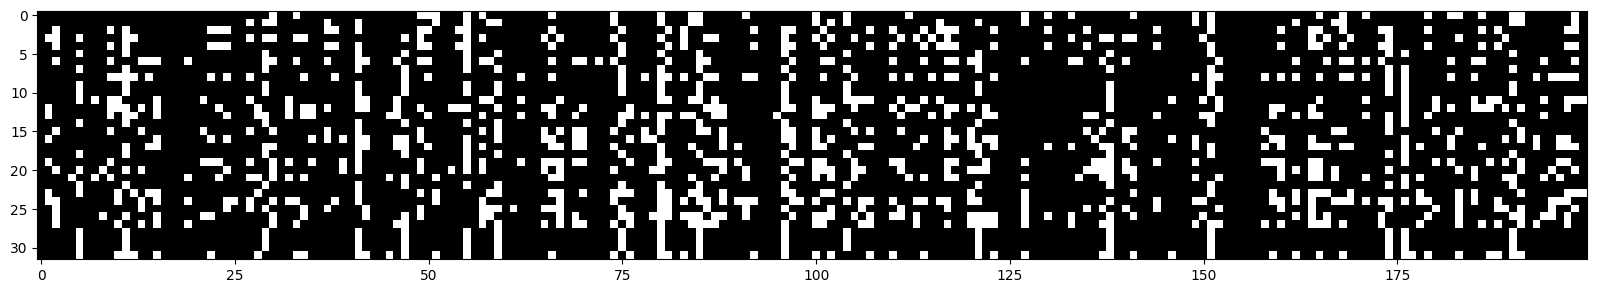

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

white columns are bad!

In [46]:
vocab_size = 27
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483657)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,  generator=g) * (5/3) /((n_embd * block_size)) **0.5 # kaiming (he) init with tanh gain (5/3) https://pytorch.org/docs/stable/nn.init.html
# b1 = torch.randn(n_hidden, generator=g)*0.01
W2 = torch.randn(n_hidden, vocab_size,  generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) * 0.1

# these are also updated during backprop
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain,bnbias]
parameters = [C, W1, W2, b2, bngain,bnbias]
print(f"{sum(p.nelement() for p in parameters)} total weights")
for p in parameters: 
    p.requires_grad = True

12297 total weights


In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X,Y

    #forward pass
    emb=C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # b1 not needed since we're subtracting the mean in the next step of batchnorm, so it basically cancels out the bias
    bnmeani = hpreact.mean(0, keepdim=True)   #this one will be no grad
    bnstdi = hpreact.std(0, keepdim=True)   #this one will be no grad
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: # print every once in a white
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3074
  10000/ 200000: 2.5834
  20000/ 200000: 2.4712
  30000/ 200000: 2.4234
  40000/ 200000: 2.4642
  50000/ 200000: 2.4604
  60000/ 200000: 2.0321
  70000/ 200000: 2.1813
  80000/ 200000: 2.6419
  90000/ 200000: 2.0634
 100000/ 200000: 1.8805
 110000/ 200000: 2.0873
 120000/ 200000: 2.0358
 130000/ 200000: 1.9317
 140000/ 200000: 2.1395
 150000/ 200000: 2.0419
 160000/ 200000: 2.2340
 170000/ 200000: 1.8527
 180000/ 200000: 1.8019
 190000/ 200000: 2.5079


In [43]:
# calibrate the batchnorm at the end of training 

with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [48]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split): 
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.024178981781006
val 2.3304545879364014


In [61]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # num of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [62]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3163


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.06%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.00%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.09%


Text(0.5, 1.0, 'activation distribution')

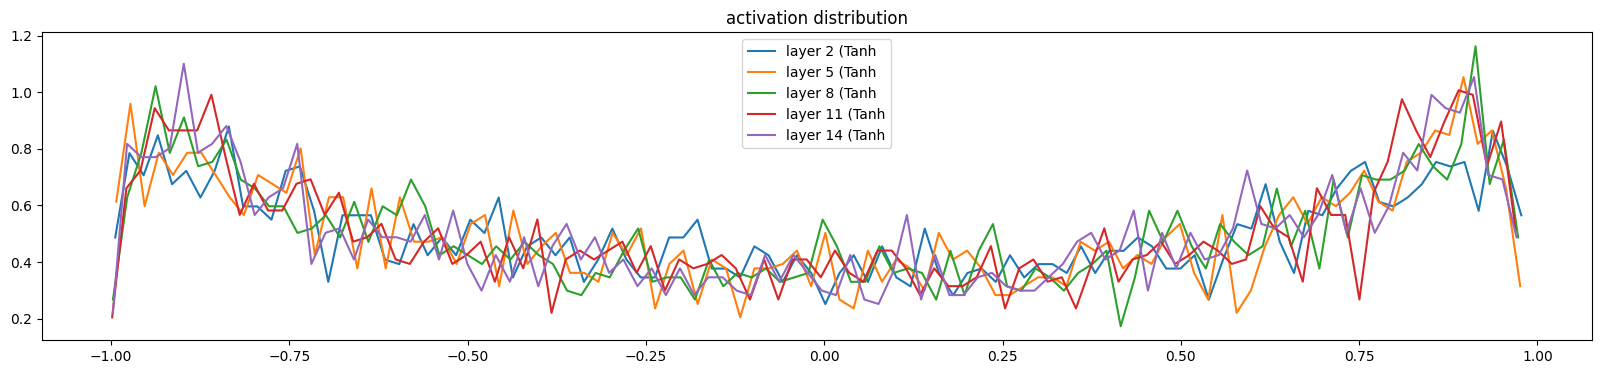

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.146953e-03
layer 5 (      Tanh): mean -0.000000, std 2.541767e-03
layer 8 (      Tanh): mean +0.000000, std 2.261608e-03
layer 11 (      Tanh): mean -0.000000, std 2.049851e-03
layer 14 (      Tanh): mean -0.000000, std 2.017092e-03


Text(0.5, 1.0, 'gradient distribution')

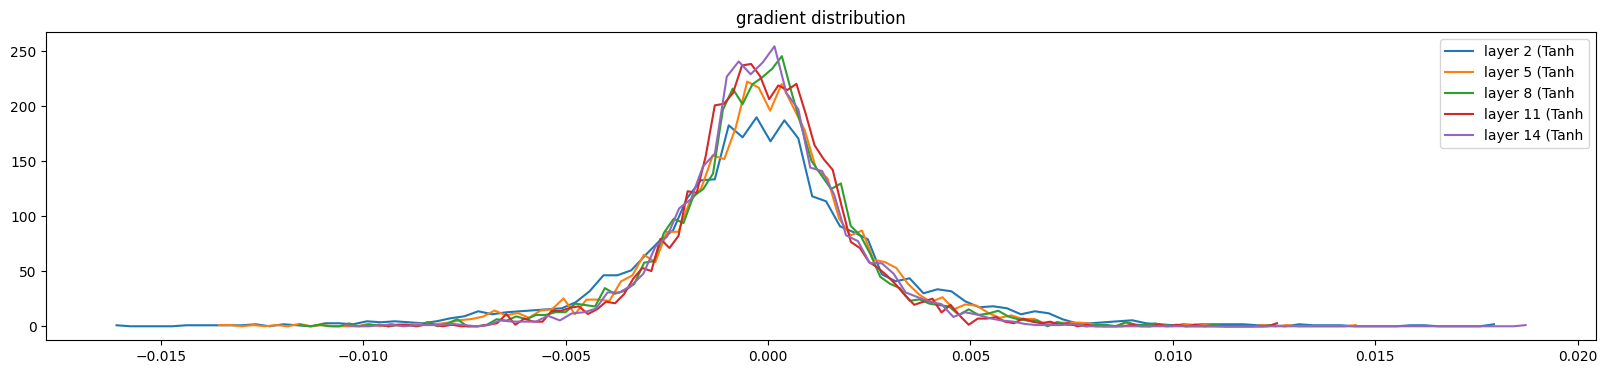

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.846099e-03 | grad:data ratio 9.836271e-03
weight  (30, 100) | mean +0.000115 | std 1.268367e-02 | grad:data ratio 6.694602e-02
weight (100, 100) | mean -0.000087 | std 9.106182e-03 | grad:data ratio 8.886331e-02
weight (100, 100) | mean +0.000089 | std 7.369705e-03 | grad:data ratio 7.178763e-02
weight (100, 100) | mean -0.000063 | std 6.585183e-03 | grad:data ratio 6.460538e-02
weight (100, 100) | mean -0.000079 | std 5.976032e-03 | grad:data ratio 5.870431e-02
weight  (100, 27) | mean +0.000009 | std 1.119275e-02 | grad:data ratio 1.073380e-01


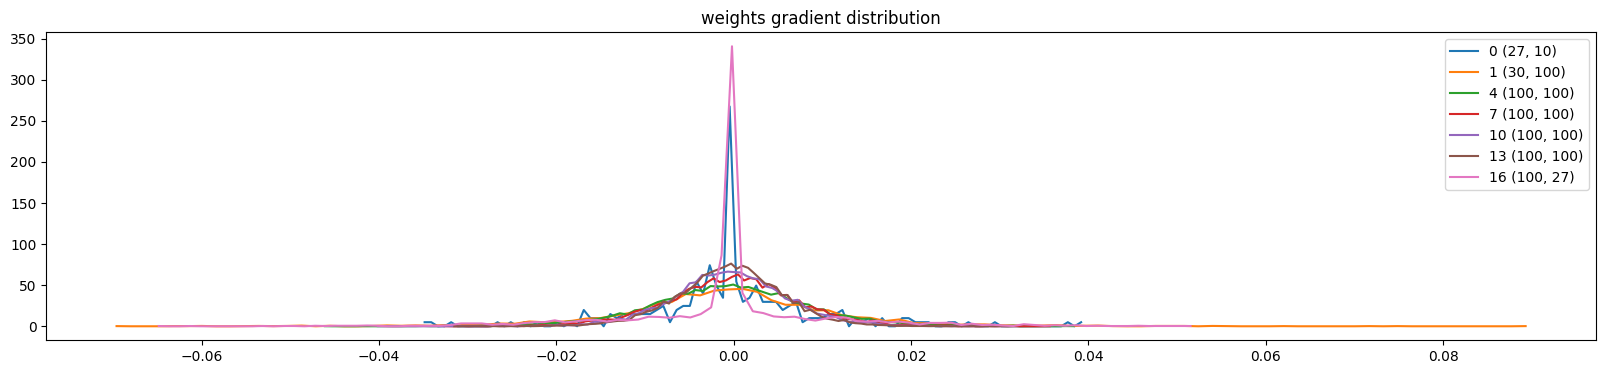

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

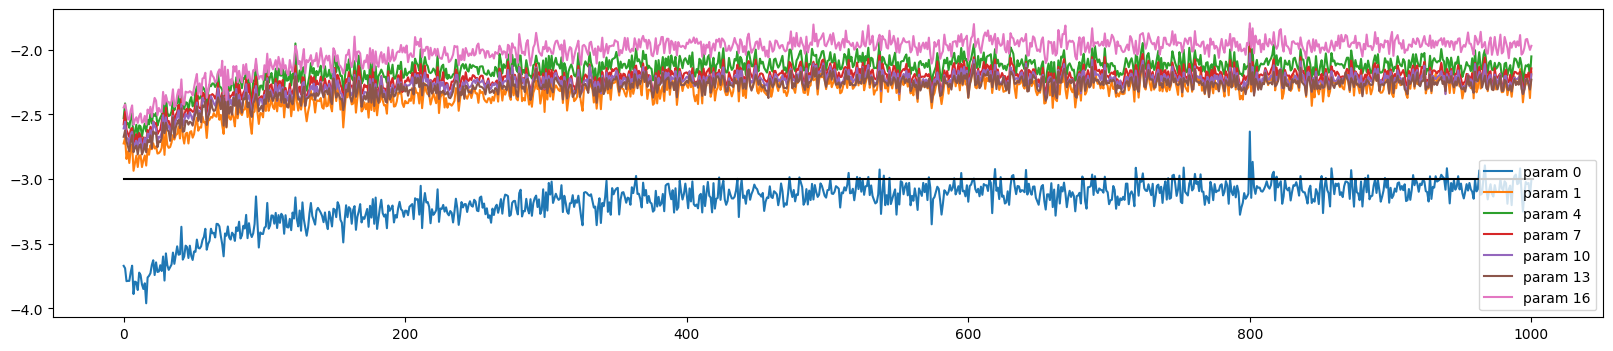

In [68]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);